<a href="https://colab.research.google.com/github/helonayala/bah/blob/main/BallinHoopNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMporting and setting up libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import svd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import signal
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler

# set random seed (reproducibility)
rseed = 42
np.random.seed(rseed)
tf.random.set_seed(rseed)
# print precision
np.set_printoptions(precision=3)

Defining important functions:
*   Regression Matrix
*   Free Run Model



In [ ]:
def matReg(y,u,ny,nu):
    # for debuging code
    # y= np.array([1, 2, 3,4,5,6,7,8,9,10])
    # u= np.array([1, 2, 3,4,5,6,7,8,9,10])

    p = np.max((ny,nu)) + 1
    N = len(y)
    Nu = len(u)
    print(Nu)

    # sanity check
    if N != Nu:
        print('Dimensions of u and y vector are not consistent')
        return (-1,-1)

    # create target vector
    target = y[p-1:N]

    # create regression matrix
    Phi = np.zeros((N-p+1,ny+nu))
    for i in range(ny):
        Phi[:,i]    = y[p-i-2: N - i-1]

    for i in range(nu):
        Phi[:,i+ny] = u[p-i-2: N - i-1]

    return (target, Phi)

def freeRun(model, y, u,ny,nu):
    p = max(ny,nu) + 1
    (N, ) = y.shape

    yhat = np.zeros(N)
    yhat[:p-1] = y[:p-1] # include initial conditions

    for k in range(p,N+1):
        # print(k)
        auxY = np.concatenate((  yhat[(k-p):(k-1)]   ,  (0,)   ),axis=0)
        auxU = np.concatenate((  u   [(k-p):(k-1)]   ,  (0,)   ),axis=0)

        _,fr_input = matReg(auxY,auxU,ny,nu)
        yhat[k-1] = model.predict(fr_input)
    # return only the values that are predictions
    # (remove the initial conditions)
    return yhat[-(N-p+1):]

Loading data from files:

*   Random step size -> training data
*   Fixed step size -> testing data



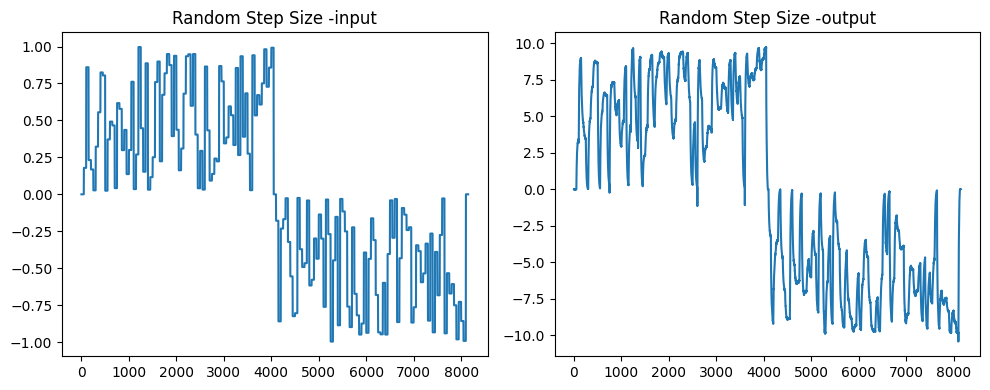

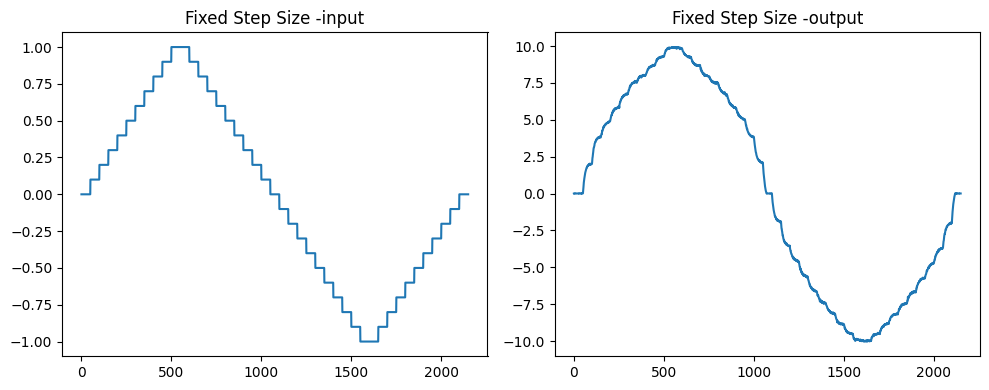

In [ ]:
filepath = "/content/drive/My Drive/PIBIC/dados/seqDegrausRand2.mat"
mat1 = loadmat(filepath)

y_rand = mat1['y']
u_rand = mat1['u']
n_rand = len(y_rand)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))


ax[0].plot(u_rand)
ax[0].set_title('Random Step Size -input')

ax[1].plot(y_rand)
ax[1].set_title('Random Step Size -output')

plt.tight_layout()
plt.show()


filepath = "/content/drive/My Drive/PIBIC/dados/seqDegrausFixo2.mat"
mat2 = loadmat(filepath)

y_fix = mat2['y']
u_fix = mat2['u']
n_fix = len(y_rand)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))


ax[0].plot(u_fix)
ax[0].set_title('Fixed Step Size -input')

ax[1].plot(y_fix)
ax[1].set_title('Fixed Step Size -output')

plt.tight_layout()
plt.show()

Normalizing data

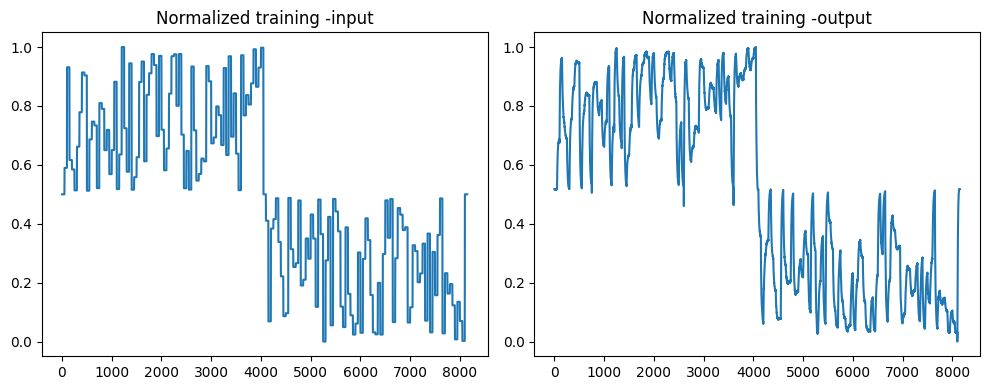

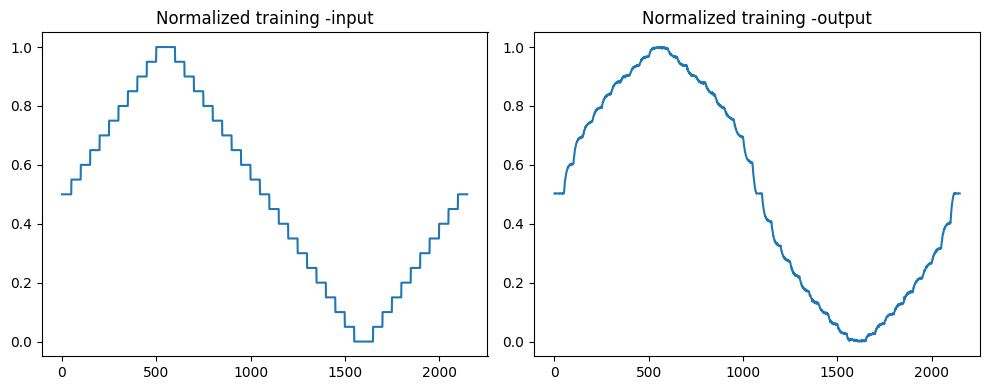

In [ ]:
normal = MinMaxScaler(feature_range=(0, 1))
x_train = normal.fit_transform(u_rand).flatten()
y_train = normal.fit_transform(y_rand).flatten()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))


ax[0].plot(x_train)
ax[0].set_title('Normalized training -input')

ax[1].plot(y_train)
ax[1].set_title('Normalized training -output')

plt.tight_layout()
plt.show()

normal = MinMaxScaler(feature_range=(0, 1))
x_test = normal.fit_transform(u_fix).flatten()
y_test = normal.fit_transform(y_fix).flatten()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))


ax[0].plot(x_test)
ax[0].set_title('Normalized training -input')

ax[1].plot(y_test)
ax[1].set_title('Normalized training -output')

plt.tight_layout()
plt.show()

Creating regression matrix

In [ ]:
print(y_train.shape)
print(n_rand)

(8150,)
8150


In [ ]:
ny = 3
nu = 2 # model orders

ye = y_train
ue = x_train

yt = y_test
ut = x_test

(Ye,Phie) = matReg(ye,ue,ny,nu)
(Yt,Phit) = matReg(yt,ut,ny,nu)

8150
2150


Defining model architecture:

In [ ]:
_ , ninp = Phie.shape
nout = 1
nneu = 80 # how many neurons per layer

# model definition
input_ = keras.layers.Input(shape=(ninp,))
hidden1 = keras.layers.Dense(nneu, activation="relu",kernel_initializer="lecun_normal",)(input_)
hidden2 = keras.layers.Dense(nneu, activation="relu",kernel_initializer="lecun_normal")(hidden1)
hidden3 = keras.layers.Dense(nneu, activation="relu",kernel_initializer="lecun_normal")(hidden2)
output = keras.layers.Dense(nout)(hidden3)

# instantiate model
model = keras.models.Model(inputs=[input_],outputs=[output])

# define optimizer and learning rate
optimizer = keras.optimizers.Nadam(learning_rate = 1e-3)

# compile model to train it
model.compile(loss="mean_squared_error", optimizer=optimizer)

In [ ]:
_ , ninp = Phie.shape
nout = 1
nneu = 80 # how many neurons per layer

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_fix, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# define optimizer and learning rate
optimizer = keras.optimizers.Nadam(learning_rate = 1e-3)

# compile model to train it
model.compile(loss="mean_squared_error", optimizer=optimizer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fitting the model

In [ ]:
history = model.fit(Phie, Ye, epochs=3, batch_size = 32)

Epoch 1/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2083e-05
Epoch 2/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1097e-05
Epoch 3/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9515e-05


Testing the model with one step ahead simulation

In [ ]:
# One step ahead
y_train_pred1 = model.predict(Phie)
y_test_pred1  = model.predict(Phit)


R2test1  = r2_score(Yt, y_test_pred1)
R2train1 = r2_score(Ye, y_train_pred1)

print('-------------- One step ahead  --------------')
print('R2test1  =')
print(R2test1)
print('R2train1  =')
print(R2train1)

255/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
-------------- One step ahead  --------------
R2test1  =
0.9998809890688257
R2train1  =
0.9998940047452108


Testing the model wih free run simulation

In [ ]:
# Free Run
# y_train_pred0 = freeRun(model,ye,ue,ny,nu)
y_test_pred0  = freeRun(model,yt,ut,ny,nu)


# R2train0 = r2_score(Ye, y_train_pred0)
R2test0  = r2_score(Yt, y_test_pred0)

print('-------------- Free Run  --------------')
print('R2test0  =')
print(R2test0)
# print('R2train0  =')
# print(R2train0)

4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
4


<ipython-input-48-fba6782880c0>:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat[k-1] = model.predict(fr_input)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4


Plotting results

In [3]:
plt.figure()
# plt.subplot(211)
# plt.plot(Ye,'k',y_train_pred0,'r')
# plt.title('Estimation')
# plt.legend(('real','prediction (FR)'))
# plt.grid()
# plt.subplot(211)
plt.plot(Yt,'k',y_test_pred0,'r')
plt.title('Test')
plt.legend(('real','prediction (FR)'))
plt.grid()
plt.show()

plt.figure()
minY = min(min(Yt),min(y_test_pred0))
maxY = max(max(Yt),max(y_test_pred0))
plt.scatter(Yt,y_test_pred0,c='red',label='Prediction')
plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.grid()
plt.legend()
plt.show()

NameError: name 'Yt' is not defined

<Figure size 640x480 with 0 Axes>